In [20]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2

# Global Variable

In [16]:
# data
path_train = 'D:/data/MNIST/train/'
path_test = 'D:/data/MNIST/test/'
#
epoch = 10
batch_size = 64
num_workers = 4

# Data

In [71]:
class Dataset_STN(Dataset):
    def __init__(self, path_image):
        list_categories = os.listdir(path_image)
        self.list_images = []
        self.list_labels = []
        self.dict_name2num = dict(zip(list_categories, range(len(list_categories))))
        self.dict_num2name = dict(zip(range(len(list_categories)), list_categories))
        print(self.dict_name2num)
        print(self.dict_num2name)
        for i, category in enumerate(list_categories):
            list_images_category = os.listdir(os.path.join(path_image, category))
            for image_category in list_images_category:
                self.list_images.append(os.path.join(path_image, category, image_category))
                self.list_labels.append(i)

    def __len__(self):
        return len(self.list_labels)

    def __getitem__(self, idx):
        image = cv2.imread(self.list_images[idx])
        image = T.from_numpy(image.transpose([2, 0, 1])).float() / 255.0
        label = self.list_labels[idx]
        return image, label

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, '和': 9}
{0: '1', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: '9', 9: '和'}


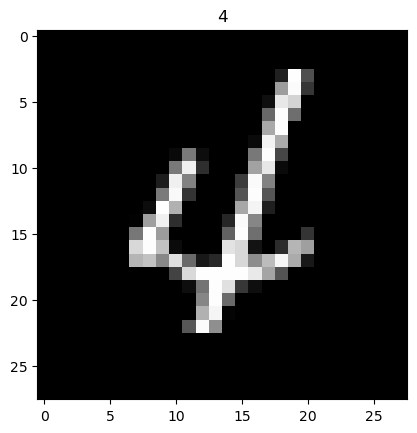

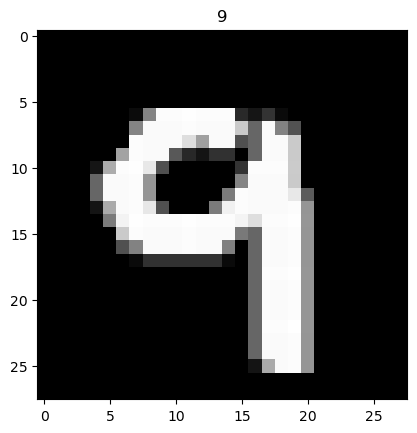

In [72]:
dataset = Dataset_STN(path_train)
dataloder = DataLoader(dataset, batch_size=1, shuffle=True)

for i, (image, label) in enumerate(dataloder):
    image = image.numpy().squeeze().transpose([1,2,0])
    plt.imshow(image)
    plt.title(dataset.dict_num2name[label.numpy().squeeze().item()])
    plt.show()
    if i==1:
        break

# Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

# Metric

In [ ]:
def metric(net, batchsize=500, path=path_test):
    net.eval()
    data = data_generator(batchsize=batchsize, path=path)
    file_name_list, _, _, _, _ = reader(path)
    N = len(file_name_list)
    n = 0
    for image, label in data:
        image = P.to_tensor(image)
        label = P.to_tensor(label)
        predict = net(image)
        n += P.sum(P.argmax(predict, 1) == P.argmax(label, 1)).numpy()
    return n/N

# Show

In [ ]:
def show(net, batchsize=8, path=path_test):
    net.eval()
    data = data_generator(batchsize=batchsize, path=path)
    image, _ = next(data)
    image_transform = P.to_tensor(image)
    image_transform = (image_transform + 1) / 2
    image_transform = image_transform.transpose([0,2,3,1]).numpy()
    for i in range(2):
        for j in range(batchsize):
            plt.subplot(2,batchsize,j)
            plt.imshow(image[j])

In [2]:
import struct
import torch


###
path = 'D:/BaiduSyncdisk/gitclone/yolov5v7.0/runs/train/扁豆3/weights/'
name = 'last'
###
pt_file = path + name + '.pt'
wts_file = path + name + '.wts'
m_type = 'detect'


print(f'Generating .wts for {m_type} model')

# Load model
print(f'Loading {pt_file}')
# device = select_device('cpu')
device = 'cpu'
model = torch.load(pt_file, map_location=device)  # Load FP32 weights
model = model['ema' if model.get('ema') else 'model'].float()

if m_type in ['detect', 'seg']:
    # update anchor_grid info
    anchor_grid = model.model[-1].anchors * model.model[-1].stride[..., None, None]
    print('anchors: ')
    print(model.model[-1].anchors * model.model[-1].stride[..., None, None])
    # model.model[-1].anchor_grid = anchor_grid
    delattr(model.model[-1], 'anchor_grid')  # model.model[-1] is detect layer
    # The parameters are saved in the OrderDict through the "register_buffer" method, and then saved to the weight.
    model.model[-1].register_buffer("anchor_grid", anchor_grid)
    model.model[-1].register_buffer("strides", model.model[-1].stride)

model.to(device).eval()

print(f'Writing into {wts_file}')
with open(wts_file, 'w') as f:
    f.write('{}\n'.format(len(model.state_dict().keys())))
    for k, v in model.state_dict().items():
        vr = v.reshape(-1).cpu().numpy()
        f.write('{} {} '.format(k, len(vr)))
        for vv in vr:
            f.write(' ')
            f.write(struct.pack('>f', float(vv)).hex())
        f.write('\n')

print('Done.')

Generating .wts for detect model
Loading D:/BaiduSyncdisk/gitclone/yolov5v7.0/runs/train/扁豆3/weights/last.pt


ModuleNotFoundError: No module named 'models'